# Fractal Aggregate Spectra in PICASO

In this tutorial, we will learn:

1. How to run virga for non-spherical cloud particles. 
2. How to generate and compare spectra for fractal aggregates vs. spheres in PICASO
3. How to compare the particle sizes and optical properties for aggregates vs. spheres

<b> This tutorial builds directly on the methods in tutorial "Fractal Aggregate Aerosols in a Hot Jupiter", using the same planet and conditions as an example. However in this tutorial, the atmosphere is set-up within PICASO and virga is called using PICASO's built-in function. The varied spectra from each choice of particle shape are then compared. </b>

Aerosols can come in a variety of shapes and sizes, which we typically characterise by their fractal dimension (Df). Under this framework, aerosols are made of collections of small spheres called monomers, and Df=3 would represent the most compact possible arrangement, whereas Df=1 would be something perfectly linear. Real aerosols are usually somewhere in-between 1 and 3, and the ultimate shape of an aerosol is usually a result of their formation conditions. VIRGA v2.0 allows us to silmultaneously model the effects of a range of different particle shapes on spectra so we can find the best fit to observational data. For further details and example of typical shapes, see Lodge & Moran et al. (2025).

Striving to maintain the simplicity and ethod of virga, aerosols can be added by providing two simple parameters:

    a) The fractal dimension (general shape) of the aerosols (which can be an array).
    b) EITHER the number of monomers (N_mon) OR the radius of the monomer (r_mon).

Figure 2 of Moran & Lodge et al. (2025) demonstrates both of the choices for (b) and explains them in detail -- see this for more guidance. in this tutorial we will choose an array of fractal dimensions, and we choose to fix the number of monomers ($N_{mon}$=1000).

Before beginning, make sure you have downloaded the new optical database for aggregates from here: https://zenodo.org/records/16581692 (which are all calculated with the assumption that $N_{mon}$=1000) and update the filepaths to the VIRGA/PICASO reference data in the first cell:

In [1]:
# --------------------------------------------- UPDATE THESE FILEPATHS FOR YOUR OWN SETUP ------------------------------------------------------------------

# first, set the locations of databases needed for picaso if you have not done this already via the code installation
#import os
#os.environ['picaso_refdata'] = '/PICASO/reference' # location of reference data
#os.environ['PYSYN_CDBS'] = '/PICASO/PYSYN_CDBS' # location of stellar data
mieff_dir = '/Users/nbatalh1/Documents/data/VIRGA_2_mieff_files' # set file paths for VIRGA v2 optical database (.mieff files) -- make sure you have downloaded the new database that includes aggregates (v2!)

# --------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
#standard import statements
import numpy as np
import pandas as pd
import astropy.units as u

#radiative transfer and atmosphere code
from picaso import justdoit as pdi

#plotting tools
from picaso import justplotit as ppi
from virga import justplotit as vpi
ppi.output_notebook()
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
import matplotlib.pyplot as plt 

/Users/nbatalh1/Documents/codes/PICASO/picaso/picaso/wavelength.py:30: SyntaxWarning: invalid escape sequence '\s'
  grid = pd.read_csv(os.path.join(__refdata__, 'opacities',filename_or_grid), sep='\s+')
/Users/nbatalh1/Documents/codes/PICASO/picaso/picaso/wavelength.py:36: SyntaxWarning: invalid escape sequence '\s'
  grid = pd.read_csv(os.path.join(filename_or_grid), sep='\s+')


/Users/nbatalh1/Documents/codes/PICASO/picaso/picaso/justplotit.py:1884: SyntaxWarning: invalid escape sequence '\d'
  """


Loading BokehJS ...

## Run PICASO to create the clear (without condensate) transmission spectrum

To start with, let's create a clear (cloud-free) transmission spectrum using the built-in Hot Jupiter profile within Picaso.

In [3]:
# First, we import the opacity values for the models of the stars. We do this using a database stored locally on our computer, and it just imports the values 
# for the specified range of wavelengths that we are interested in (rather than all possible opacities for all star types at all wavelengths)

opacity = pdi.opannection(wave_range=[0.3,15]) # import opacities for stellar models between the range: 0.3 um -> 15 um
jupiter = pdi.inputs() # initialise planet atmosphere in PICASO

jupiter.phase_angle(0) # set phase angle to 0

# SET PLANET PARAMETERS: 

planet_mass = 1 # M_Jup
planet_radius = 1 # R_Jup

jupiter.gravity(mass=planet_mass, mass_unit=pdi.u.Unit('M_jup'), radius=planet_radius, radius_unit=pdi.u.Unit('R_jup')) # order: planet mass, unit, planet radius, unit

# INPUT STELLAR PARAMETERS: 

stellar_temperature = 5700 # K
stellar_metallicity = 0 # (Fe/H) dex
stellar_surface_gravity = 4.5 # (log g) cgs units
stellar_radius = 1 # R_Sun

jupiter.star(opacity, stellar_temperature, stellar_metallicity, stellar_surface_gravity, radius=stellar_radius, radius_unit = pdi.u.Unit('R_sun') ) # order: Opacity database, Temperature, Metallicity, Surface gravity (log g), Radius, Radius unit

# ADD THE ATMOSPHERIC CHEMISTRY 

jupiter.atmosphere(filename=pdi.HJ_pt(), sep=r'\s+')

Our planet is complete! Let's compute and plot our cloud-free transmission spectrum:

In [4]:
# Ask PICASO to do all of the radiative transfer calculations and compute the transmission spectrum for the clear model
clear_spectrum= jupiter.spectrum(opacity, full_output=True,calculation='transmission')

# create list to store all spectra
all_spectra=[]

# regrid to resolution R=300
wno, rprs2 = pdi.mean_regrid(clear_spectrum['wavenumber'] , clear_spectrum['transit_depth'], R=300)
full_output = clear_spectrum['full_output']

# store cloudy spectrum for clear case
all_spectra.append(rprs2*1e6)

# set custom colors for cloud species
cloud_colors = ['#ce3fce', '#7cf2fb', '#33b9cc', '#1c7bb8', '#295091', '#212255'] # order: spheres, 1.2, 1.6, 2.0, 2.4, 2.8
spectra_colors = ['#bcbcbd'] + cloud_colors # add an extra element for the clear model for when plotting spectra. New order: clear, spheres, 1.2, 1.6, 2.0, 2.4, 2.8

# plot spectrum
ppi.show(ppi.spectrum(wno,rprs2*1e6,plot_width=900,plot_height=300, palette=spectra_colors[0:1]))

## Adding Mg<sub>2</sub>SiO<sub>4</sub> Clouds with Spherical Particles

Mg<sub>2</sub>SiO<sub>4</sub> is a typical cloud species in Hot Jupiter environments -- let's add some spherical cloud particles to start with. This time, we pass all important cloud variables directly to the .virga function from within PICASO.

In [5]:
# Set Kzz, metallicity and mean molecular weight 
metallicity = 1 #atmospheric metallicity relative to Solar
mean_molecular_weight = 2.3 # atmospheric mean molecular weight
constant_kzz = 10**10 # constant Kzz
f_sed = 0.5 # sedimentation efficiency
sigma_width = 2 # width of lognormal distribution
aggregate_species = ['Mg2SiO4'] # Aggregate species

kz = np.zeros(len(jupiter.inputs['atmosphere']['profile']))+ constant_kzz # make a constant Kzz profile as an array
jupiter.inputs['atmosphere']['profile']['kz'] = kz # add this Kzz profile to the PICASO inputs

# make a copy of the clear spectrum
cloudy_jupiter_spheres = jupiter

# run virga: this will determine where the clouds are, what particles sizes they are made from, and how opaque they are at each pressure level
clouds_from_virga_spheres = cloudy_jupiter_spheres.virga(aggregate_species, directory=mieff_dir, 
                                                         fsed=f_sed, mh=metallicity, mmw = mean_molecular_weight, 
                                                         sig=sigma_width, aggregates=False) # Add the Mg2SiO4 clouds! The function '.virga' runs VIRGA from within PICASO, using all of the same atmosphere values etc, so that we don't have to set them again

# calculate a transmission spectrum for this new (cloudy) model (with added Mg2SiO4) and regrid to a resolution of R=300
cloudy_spectrum = cloudy_jupiter_spheres.spectrum(opacity, full_output=True, calculation='transmission')
cloud_wno,cloud_rprs2 = pdi.mean_regrid(cloudy_spectrum['wavenumber'] , cloudy_spectrum['transit_depth'], R=300)

# store cloudy spectrum for spheres
all_spectra.append(cloud_rprs2*1e6)

# show transmission spectrum
print(f'For Spheres:')
ppi.show(ppi.spectrum([wno,cloud_wno],[(rprs2*1e6),(cloud_rprs2*1e6)],
                legend=['No Mg2SiO4','With Mg2SiO4'],plot_width=900,plot_height=300, palette=spectra_colors[0:2])) # palette argument simply assigns custom colors to match plots below

For Spheres:


## p-T profile

To view the p-T profile and get an idea of where in the atmosphere our Mg<sub>2</sub>SiO<sub>4</sub> condensates are forming into clouds, we can use virga's usual pt() function.

In [6]:
# Plot pressure-Temperature profile
show(vpi.pt(clouds_from_virga_spheres,plot_height=450))

## ADDING FRACTAL AGGREGATE CLOUDS

Now let's add fractal aggregate clouds to our clear model instead of spheres.

In [7]:
# Set a range of fractal dimensions to explore (a different model will be run each time). This can be a single value or an array. 
# In this example, we will choose the values [1.2, 1.6, 2.0, 2.4, 2.8]:
d_f_values = np.linspace(1.2,2.8,5)

# make a copy of the clear spectrum for each d_f value
cloudy_jupiter_list=[]
for i in range(len(d_f_values)):
    cloudy_jupiter_list.append(jupiter) # copy the clear spectrum

# create a list to store all of the different cloud models for each fractal dimension
clouds_from_virga_fractals=[]

# loop over all particle shapes
for i in range(len(d_f_values)):

    d_f = d_f_values[i]
    N_monomers = 1000 # Here we provide the number of monomers. If you prefer to provide r_mon instead, set it here (but note that it needs to be in cm, not um), and submit r_mon instead of N_mon in the .virga() function below

    # That's it -- Df and N_mon are all you need to prescribe for aggregates! More details on other typical aggregate parameters below for experts:
    # k0 will usually be calculated using Eq. 14+15 of Moran & Lodge et al. (2025), but this can be prescribed here if you wish to use a fixed value.
    # Radius of gyration will be calculated within the code: virga can calculate the mass of the each aggregate, meaning that r_mon can be calculated
    # from N_mon (or vice versa). k0 is calculated as stated above, so including Df we have everything we need to find R_gyr using Eq. 2 of Moran & Lodge 
    # et al. (2025)

    # take the clear atmosphere (cloudy_jupiter_list[i]) and run virga to find the clouds for each fractal dimension (using aggregates=True and our aggregate parameters). 
    # this method saves each cloud model as a new model in a list (clouds_from_virga_fractals).
    clouds_from_virga_fractals.append(cloudy_jupiter_list[i].virga(aggregate_species,  # Add the Mg2SiO4 clouds! The function '.virga' runs VIRGA from within PICASO, using all of the same atmosphere values etc, so that we don't have to set them again
                                                                   directory=mieff_dir, # location of .mieff files
                                                                   fsed=f_sed, # f_sed
                                                                   mh=metallicity, # metallicity
                                                                   mmw = mean_molecular_weight, # mean molecular weight of atmosphere
                                                                   sig=sigma_width, # width of lognormal distribution
                                                                   aggregates=True, # model cloud particles as aggregates
                                                                   Df=d_f, # fractal dimension of aggregates
                                                                   N_mon=N_monomers)) # number of monomers in an aggregate

    # calculate a transmission spectrum for this new (cloudy) model (with added Mg2SiO4) and regrid to a resolution of R=300
    cloudy_spectrum = cloudy_jupiter_list[i].spectrum(opacity, full_output=True, calculation='transmission')
    cloud_wno,cloud_rprs2 = pdi.mean_regrid(cloudy_spectrum['wavenumber'] , cloudy_spectrum['transit_depth'], R=300)
    
    # store spectrum for each fractal
    all_spectra.append(cloud_rprs2*1e6)
    
    # show transmission spectrum for each fractal dimension
    print(f'For d_f = {d_f}:')
    ppi.show(ppi.spectrum([wno,cloud_wno],[(rprs2*1e6),(cloud_rprs2*1e6)],
                  legend=['No Mg2SiO4','With Mg2SiO4'],plot_width=900,plot_height=300, palette=list(spectra_colors[i] for i in [0,(i+2)]))) # the palette argument iterates through the list of custom colors so that fractal has a new color

Optics file found. Reading data from: /Users/nbatalh1/Documents/data/VIRGA_2_mieff_files/Mg2SiO4_aggregates_Df_1.200000.mieff.


Take caution in analyzing results. Particle sizes were predicted by eddysed() that were larger than the maximum radius in the .mieff file (0.01 cm). The optics and number densities for these particles will therefore not be correct. This can be solved by recreating the .mieff grids with a larger r_max. The errors occurred at the following pressure layers:
Particles of radius 0.010127903126961036 cm were found (where rmax from the mieff file is 0.01 cm) for gas 0 in the 74th altitude layer
Particles of radius 0.010266782164672278 cm were found (where rmax from the mieff file is 0.01 cm) for gas 0 in the 75th altitude layer
Particles of radius 0.010410121119530595 cm were found (where rmax from the mieff file is 0.01 cm) for gas 0 in the 76th altitude layer
Particles of radius 0.010554948303511485 cm were found (where rmax from the mieff file is 0.01 cm) for gas 0 in the 77th altitude layer
Particles of radius 0.010695714532714508 cm were found (where rmax from the mieff file is 0.01 cm) 

For d_f = 1.2:


Optics file found. Reading data from: /Users/nbatalh1/Documents/data/VIRGA_2_mieff_files/Mg2SiO4_aggregates_Df_1.600000.mieff.


For d_f = 1.5999999999999999:


Optics file found. Reading data from: /Users/nbatalh1/Documents/data/VIRGA_2_mieff_files/Mg2SiO4_aggregates_Df_2.000000.mieff.


For d_f = 2.0:


Optics file found. Reading data from: /Users/nbatalh1/Documents/data/VIRGA_2_mieff_files/Mg2SiO4_aggregates_Df_2.400000.mieff.


For d_f = 2.4:


Optics file found. Reading data from: /Users/nbatalh1/Documents/data/VIRGA_2_mieff_files/Mg2SiO4_aggregates_Df_2.800000.mieff.


For d_f = 2.8:


# Aggregate Analysis Tools

We've made our clouds! Now let's see how the aggregates compared to spheres. There are a number of tools that have been added to compare between the different models, and each one can give you interesting diagnostic information. Let's explore them one-by-one. First, set-up the figure size, location of the directories that hold the data, and the min/max wavelength to plot.

In [8]:
# set figure size in notebook
plt.rcParams['figure.figsize'] = [15, 10]

# set min and max wavelength to show on plots
min_wavelength = 0.3 # in um
max_wavelength = 15 # in um

## Comparing the Spectra

This tool plots the transmission spectrum for each of the different fractal dimensions, on log-axes this time (so they look a little different to the plots above).

In [9]:
# plot spectra - compare the transmission spectrum for each of the different fractal dimensions, on log x-axis this time

ppi.show(ppi.spectrum([wno]*7,[all_spectra],
            legend=['clear', 'spheres', '1.2', '1.6', '2.0', '2.4', '2.8'],
            plot_width=1100,plot_height=600, 
            x_axis_type='log', 
            palette=spectra_colors))

<b>Interpretation:</b> In this example, the Df=1.2 shapes are the least opaque and have the smallest transit depth of all of the different shapes modeled. Note that this isn't always the case (see Lodge & Moran 2025 for examples where the opposite is true!).

## Visualising Particle Sizes in each Pressure Layer

Virga will typically find different particle sizes for different aggregate shapes because of how they behave dynamically (see Moran & Lodge et al. 2025). Lower fractal dimensions tend to form into larger particles (because they have slower fall speed vs compact spheres. However, the upwards forces are the same in both versions of the model. Therefore, the aggregates need to form into more massive particles to stay stable against the same upwards velocity from Kzz/convection). The mean particle sizes that virga found for each shape can be seen and compared using the tool below. 

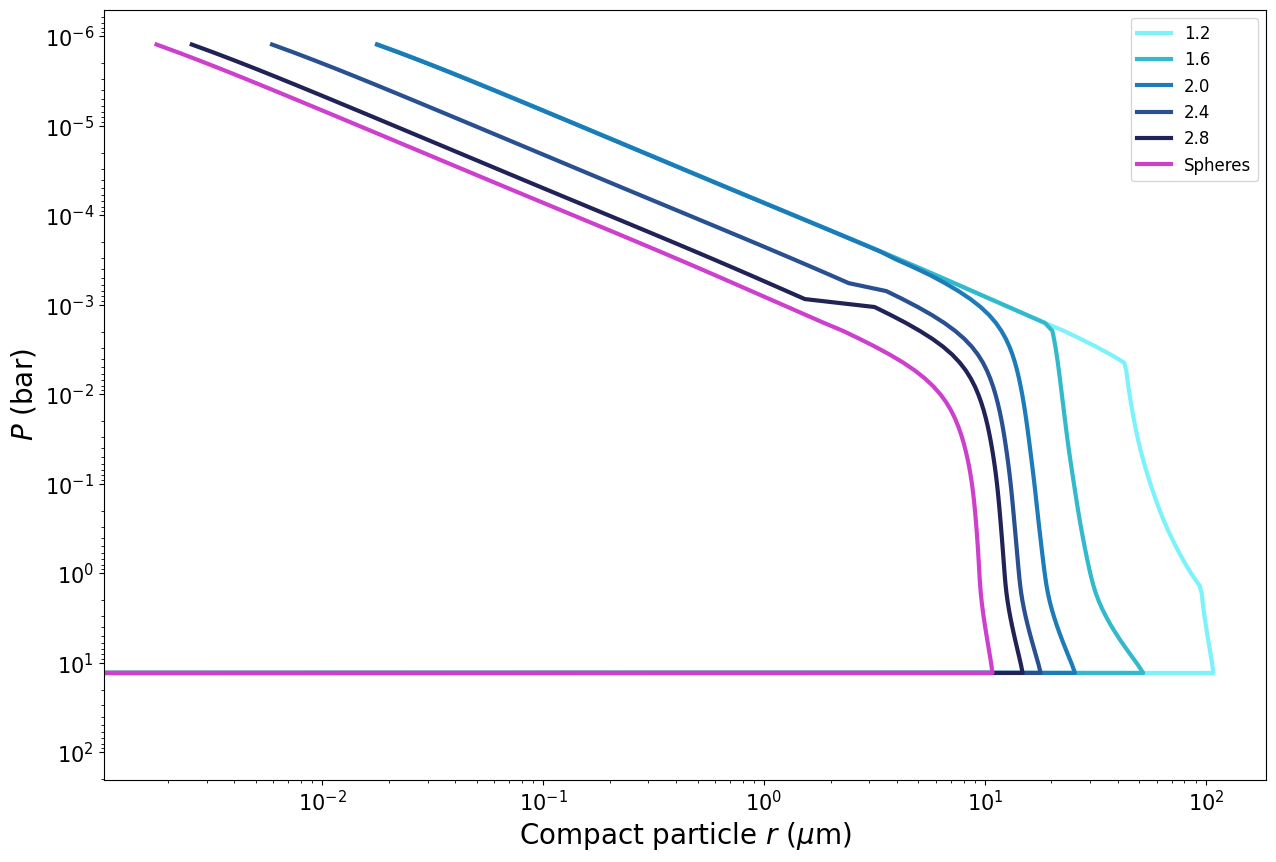

In [10]:
vpi.aggregates_pressure_vs_radius(clouds_from_virga_spheres, clouds_from_virga_fractals, d_f_list=d_f_values, colors=cloud_colors)


<b>Interpretation:</b> The Df=1.2 model has the largest particles, which are at the bottom of the cloud-deck. In all models, cloud particles get smaller as altitude increases.

## Probing the relationship between Pressure, Radius and Number Density

Because the same amount of condensate is condensing out in each model in virga (regardless of particle shape), if the low fractal dimensions form into larger particles, there must be fewer of them. Plotting the number density at each pressure layer shows demonstrates this balance between particle size and number density visually with altitude. The marker size indicates particle size. 

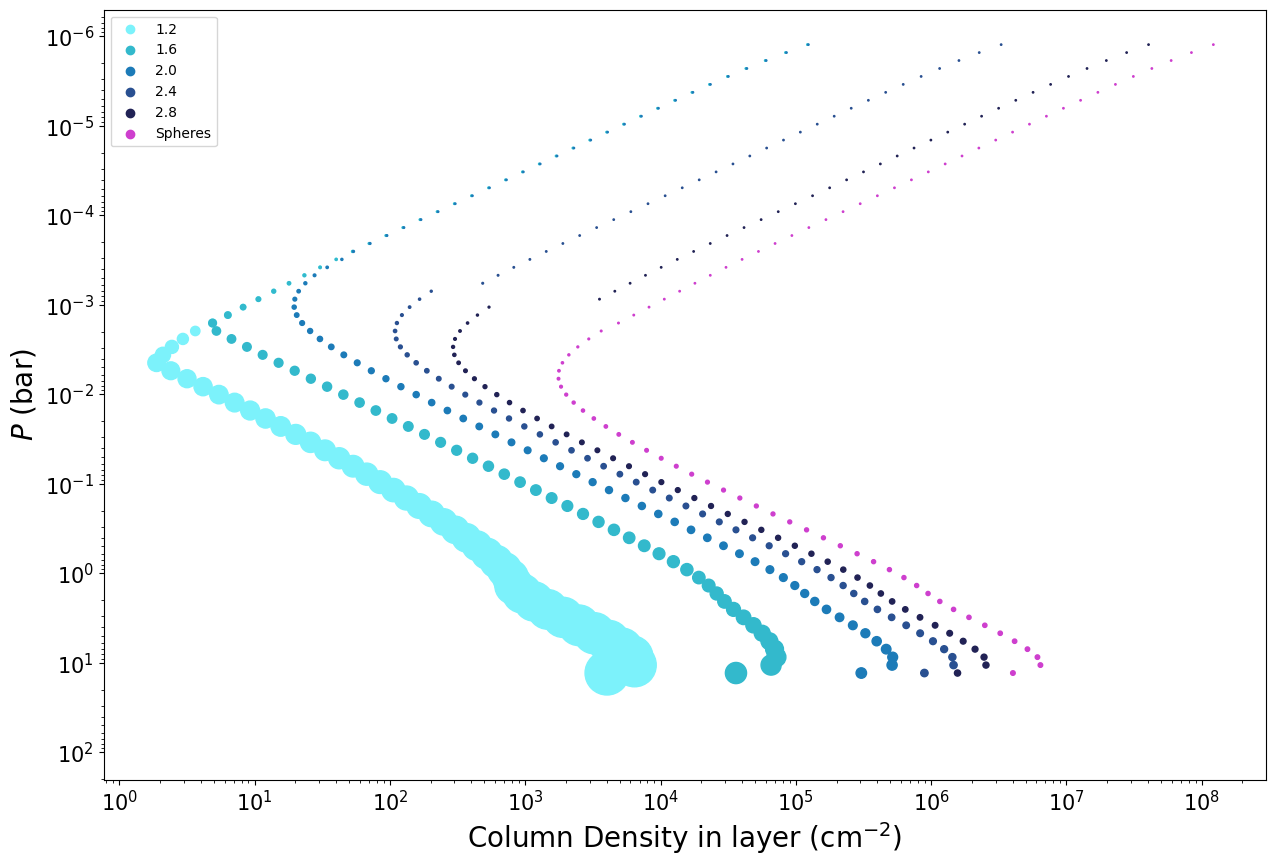

In [11]:
vpi.aggregates_pressure_vs_number_density(clouds_from_virga_spheres, clouds_from_virga_fractals, d_f_list=d_f_values, colors=cloud_colors)

<b>Interpretation:</b> The Df=1.2 clouds are shown to be made of fewer (but larger) particles than in the other models.

## Visualising .mieff files and Optical Properties

This tool allows you to see how the optical properties of the cloud particles vary with shape. $Q_{ext}$ represents how efficiently they will absorb and scatter radiation, and it is a function of particle size, wavelength and shape. This reads all of the data from the .mieff database and plots $Q_{ext}$ for all particle sizes (blue = smallest particles in the grid, green = largest particles in the grid).


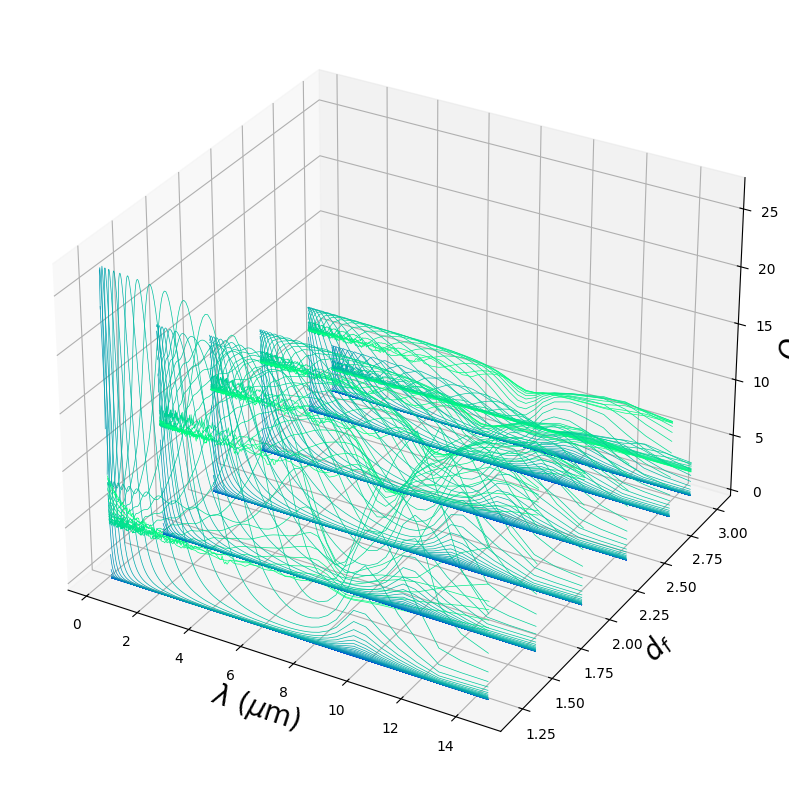

In [12]:
# plot Q_ext as a function of wavelength for each fractal dimension
vpi.aggregates_optical_properties(aggregate=aggregate_species[0], mieff_dir=mieff_dir, d_f_list=d_f_values, min_wavelength=min_wavelength, max_wavelength=max_wavelength)

<b>Interpretation:</b> This is usually a busy plot, but gives some intuition into how linear and compact aggregates compare to their spherical counterparts. Here the linear fractals with Df = 1.2 are the most opaque at short wavelengths. We saw that these particles are the least opaque in the transmission spectrum, which is because their number density is so much lower as shown in the previous figure.

These plots can highlight resonance features and aid in checking that your optics are behaving as expected for a particular chemical species.

## Checking that Particle Radii are within the .mieff Grid

It's important that virga finds particles that are within the range of optical properties in the .mieff grid, otherwise virga may underpredict or overpredict the opacity of the particles. Virga will give warnings if it finds particles off-grid, but this plot is a quick visual check to see if and where that happens:

For the Mg2SiO4.mieff file (spheres):

	 Wavelengths are between 0.268 --> 29.700 um in 189 intervals.
	 Radii are between 0.0001 --> 100.0 um in 60 intervals.








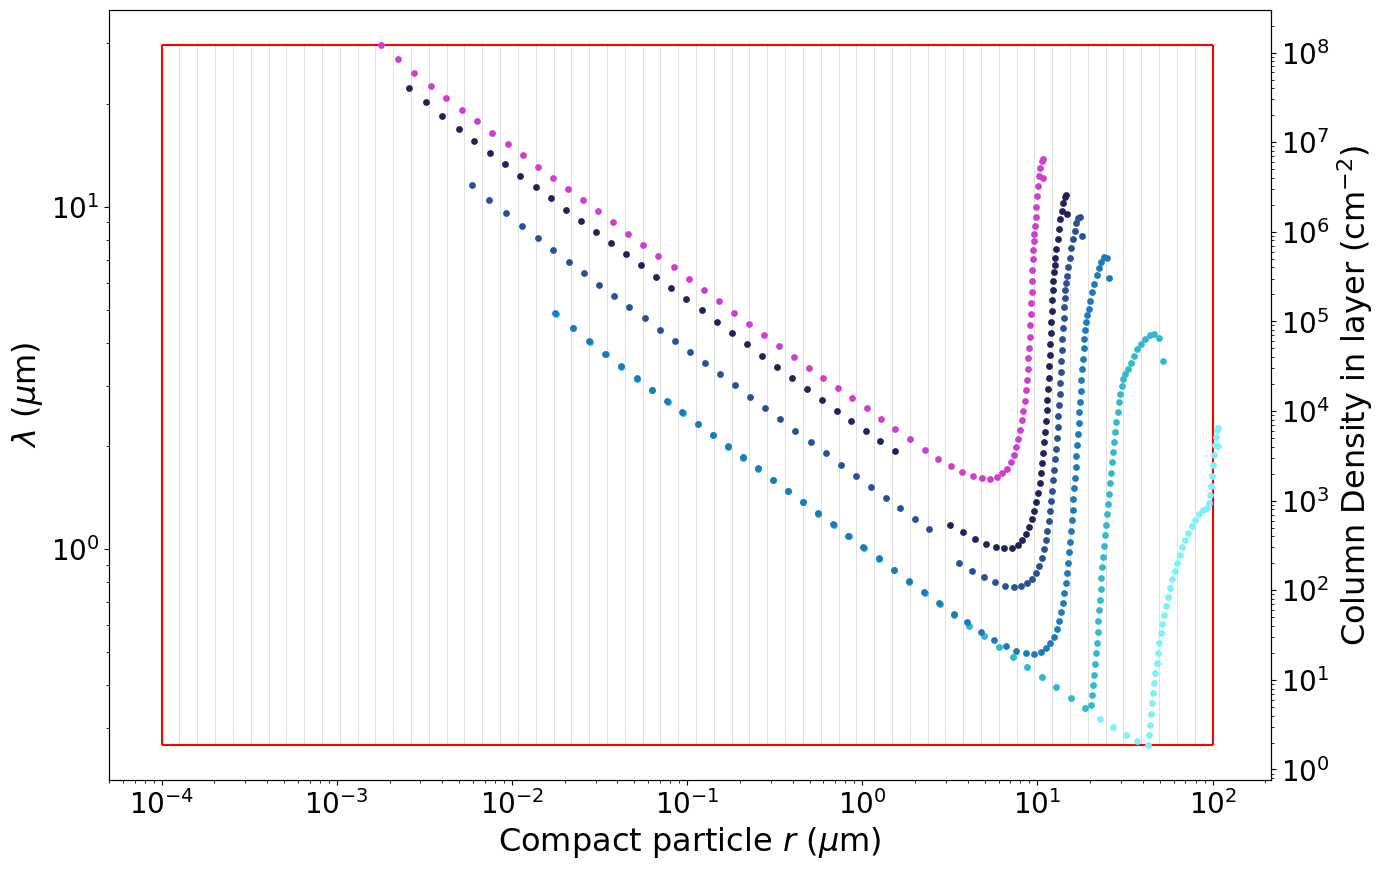

In [13]:
vpi.aggregates_wavelength_radius_grid(clouds_from_virga_spheres, clouds_from_virga_fractals, aggregate=aggregate_species[0], d_f_list=d_f_values, mieff_dir=mieff_dir, colors=cloud_colors)

<b>Interpretation:</b> 
- The red outline box marks the extremes of the .mieff grid, with faint red vertical lines representing the grid spacing in radius.
- The vertical extent of the box is just to show the wavelength range in the .mieff files. The colored markers show the column density so that we have an indication of how many particles were in each radius bin for each model.
- The "radius" of an aggregate is defined as the compact radius (the radius of a sphere made from the same volume of material) and this is how they are stored in the .mieff files. The particle sizes obtained by virga at each pressure layer and for each fractal dimension are plotted on this grid as markers, and these should all ideally be inside the horizontal bounds of the red box. If not, you may need to adjust your Kzz/fsed values (both of these can effect particle size), or make a new .mieff grid (see next tutorial!). It's ok for the particles to be near the vertical bounds of the red box -- the marker y-positions just scale with column density, so they will always sit on the top/bottom edge of the box.